## NHL Season Playoff Outcome Logistic Regression EDA

### Description

The following EDA analysis explores NHL team season data from 1983 - 2020 to predict playoff outcomes by adjusted games a team wins **(wins + (ties / 2))** above the mean adjusted wins of any given season (season outcome). 

More than 60% of teams make the playoffs, so the logistic regression sets out to predict teams that don't make the playoffs. 

The entirety of this analysis seeks to understand the statistical economics of what team organizations need to achieve to make playoffs by understanding the economics of what doesn't work to make playoffs. Team organizations can gain more transparency and perspective on what may help in strategizing for successful campaigns.

In [1]:
# Import libraries
import pandas as pd
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
from ipynb.fs.full.Preprocessing_Functions import *
from pickle import dump
from pickle import load

### Data Preprocessing and Feature Engineering

In [13]:
# Import NHL team season stats data frame
nhl_df3 = pd.read_csv('Data/1983_2020_NHL_Season_Data.csv')

# Convert year range feature into a string data type
nhl_df3['year_range'] = nhl_df3['year_range'].astype(str)

# Drop uneeded features
nhl_df3 = nhl_df3.drop(['Unnamed: 0', 'id'], axis = 1)

# Failed shots per game feature
nhl_df3['failedShotsPerGame'] = nhl_df3['shotsPerGame'] * (1 - (nhl_df3['shootingPctg'] / 100))
# Saves per game feature
nhl_df3['savesPerGame'] = nhl_df3['shotsAllowed'] * nhl_df3['savePctg']

# Percentage of game won where the team scored first feature
# Teams who win 61% of the time they score first are labeled as high and the opposite as low
nhl_df3['winScoreFirstGreater61'] = nhl_df3['winScoreFirst']
nhl_df3['winScoreFirstGreater61'][nhl_df3['winScoreFirstGreater61'] > 0.611] = 'high'
nhl_df3['winScoreFirstGreater61'][nhl_df3['winScoreFirstGreater61'] != 'high'] = 'low'

# Tie games feature
nhl_df3['ties'] = nhl_df3['gamesPlayed'] - nhl_df3['wins'] - nhl_df3['losses']

# Adjusted wins calculated as total wins plus ties where two ties equate to one game won
nhl_df3['adjWins'] = nhl_df3['wins'] + (nhl_df3['ties'] / 2)

# Print data summary
print('\n')
nhl_df3.info()
nhl_df3.head()



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 895 entries, 0 to 894
Data columns (total 35 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   gamesPlayed             895 non-null    int64  
 1   wins                    895 non-null    int64  
 2   losses                  895 non-null    int64  
 3   ot                      895 non-null    int64  
 4   pts                     895 non-null    int64  
 5   ptPctg                  895 non-null    float64
 6   goalsPerGame            895 non-null    float64
 7   goalsAgainstPerGame     895 non-null    float64
 8   evGGARatio              895 non-null    float64
 9   powerPlayPercentage     895 non-null    float64
 10  powerPlayGoals          895 non-null    float64
 11  powerPlayGoalsAgainst   895 non-null    float64
 12  powerPlayOpportunities  895 non-null    float64
 13  penaltyKillPercentage   895 non-null    float64
 14  shotsPerGame            895 non-null    

,gamesPlayed,wins,losses,ot,pts,ptPctg,goalsPerGame,goalsAgainstPerGame,evGGARatio,powerPlayPercentage,powerPlayGoals,powerPlayGoalsAgainst,powerPlayOpportunities,penaltyKillPercentage,shotsPerGame,shotsAllowed,winScoreFirst,winOppScoreFirst,winLeadFirstPer,winLeadSecondPer,winOutshootOpp,winOutshotByOpp,faceOffsTaken,faceOffsWon,faceOffsLost,faceOffWinPercentage,shootingPctg,savePctg,name,year_range,failedShotsPerGame,savesPerGame,winScoreFirstGreater61,ties,adjWins
0,80,17,56,0,41,25.6,2.888,4.375,0.6780,14.3,52.0,83.0,363.0,75.3,26.3875,32.0000,0.464,0.077,0.571,0.765,0.348,0.188,0.0,0.0,0.0,0.0,10.9,0.863,New Jersey Devils,19831984,23.511263,27.616000,low,7,20.5
1,80,50,26,0,104,65.0,4.463,3.363,1.3722,22.5,63.0,66.0,280.0,81.5,30.2750,33.3875,0.791,0.432,0.853,0.933,0.857,0.532,0.0,0.0,0.0,0.0,14.7,0.899,New York Islanders,19831984,25.824575,30.015363,high,4,52.0
2,80,42,29,0,93,58.1,3.925,3.800,1.0392,25.1,74.0,76.0,295.0,78.1,31.8875,31.5500,0.619,0.421,0.828,0.969,0.675,0.467,0.0,0.0,0.0,0.0,12.3,0.880,New York Rangers,19831984,27.965338,27.764000,high,9,46.5
3,80,44,26,0,98,61.3,4.375,3.625,1.3646,20.2,64.0,85.0,317.0,76.6,36.7500,28.6500,0.667,0.400,0.813,0.875,0.720,0.286,0.0,0.0,0.0,0.0,11.9,0.873,Philadelphia Flyers,19831984,32.376750,25.011450,high,10,49.0
4,80,16,58,0,38,23.8,3.175,4.875,0.6466,20.9,71.0,86.0,339.0,76.0,28.3375,36.3500,0.316,0.095,0.421,0.737,0.364,0.183,0.0,0.0,0.0,0.0,11.2,0.866,Pittsburgh Penguins,19831984,25.163700,31.479100,low,6,19.0


The above code imports the original data for seasons 1983 - 2020. 

Intuitively  Unnamed: 0 (row index) and id (team id) are removed from the data.

additional features are derived:

* **Failed shots per game (failedShotsPerGame)** - Shots that did not translate into goals.<br><br>
* **Saves per game (savesPerGame)** - Shots against that did not translate into goals against.<br><br>
* **Ties per season (ties)** - (total games per season - (wins + losses)).<br><br>
* **Win percentage when teams scored first (winScoreFirstGreater61)** - Teams that won **greater than 61%** of the games where they scored first are labeled **high** and teams that won **less or equal to 61%** of the games where they scored first are labeled **low**. This variable was derived using CHAID decision tree algorithm to find significant relationships within the data. <br><br>
* **Adjusted wins (adjWins)** - (total wins + (ties / 2)).<br>

In [14]:
# Import NHL team season stats data frames with failed playoff outcomes
nhl_df4 = pd.read_csv('Data/NHL_1983_2020_Playoff_Data.csv')
# Retain failed_playoff_flag column
nhl_df4 = nhl_df4[['failed_playoff_flag']]

# Combine both nhl_df3 and nhl_df4 data frames 
nhl_df5 = pd.concat([nhl_df3, nhl_df4], axis = 1)

# Print data summary
print('\n')
nhl_df5.info()
nhl_df5.head()



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 895 entries, 0 to 894
Data columns (total 36 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   gamesPlayed             895 non-null    int64  
 1   wins                    895 non-null    int64  
 2   losses                  895 non-null    int64  
 3   ot                      895 non-null    int64  
 4   pts                     895 non-null    int64  
 5   ptPctg                  895 non-null    float64
 6   goalsPerGame            895 non-null    float64
 7   goalsAgainstPerGame     895 non-null    float64
 8   evGGARatio              895 non-null    float64
 9   powerPlayPercentage     895 non-null    float64
 10  powerPlayGoals          895 non-null    float64
 11  powerPlayGoalsAgainst   895 non-null    float64
 12  powerPlayOpportunities  895 non-null    float64
 13  penaltyKillPercentage   895 non-null    float64
 14  shotsPerGame            895 non-null    

,gamesPlayed,wins,losses,ot,pts,ptPctg,goalsPerGame,goalsAgainstPerGame,evGGARatio,powerPlayPercentage,powerPlayGoals,powerPlayGoalsAgainst,powerPlayOpportunities,penaltyKillPercentage,shotsPerGame,shotsAllowed,winScoreFirst,winOppScoreFirst,winLeadFirstPer,winLeadSecondPer,winOutshootOpp,winOutshotByOpp,faceOffsTaken,faceOffsWon,faceOffsLost,faceOffWinPercentage,shootingPctg,savePctg,name,year_range,failedShotsPerGame,savesPerGame,winScoreFirstGreater61,ties,adjWins,failed_playoff_flag
0,80,17,56,0,41,25.6,2.888,4.375,0.6780,14.3,52.0,83.0,363.0,75.3,26.3875,32.0000,0.464,0.077,0.571,0.765,0.348,0.188,0.0,0.0,0.0,0.0,10.9,0.863,New Jersey Devils,19831984,23.511263,27.616000,low,7,20.5,1
1,80,50,26,0,104,65.0,4.463,3.363,1.3722,22.5,63.0,66.0,280.0,81.5,30.2750,33.3875,0.791,0.432,0.853,0.933,0.857,0.532,0.0,0.0,0.0,0.0,14.7,0.899,New York Islanders,19831984,25.824575,30.015363,high,4,52.0,0
2,80,42,29,0,93,58.1,3.925,3.800,1.0392,25.1,74.0,76.0,295.0,78.1,31.8875,31.5500,0.619,0.421,0.828,0.969,0.675,0.467,0.0,0.0,0.0,0.0,12.3,0.880,New York Rangers,19831984,27.965338,27.764000,high,9,46.5,0
3,80,44,26,0,98,61.3,4.375,3.625,1.3646,20.2,64.0,85.0,317.0,76.6,36.7500,28.6500,0.667,0.400,0.813,0.875,0.720,0.286,0.0,0.0,0.0,0.0,11.9,0.873,Philadelphia Flyers,19831984,32.376750,25.011450,high,10,49.0,0
4,80,16,58,0,38,23.8,3.175,4.875,0.6466,20.9,71.0,86.0,339.0,76.0,28.3375,36.3500,0.316,0.095,0.421,0.737,0.364,0.183,0.0,0.0,0.0,0.0,11.2,0.866,Pittsburgh Penguins,19831984,25.163700,31.479100,low,6,19.0,1


An identical data frame is imported, however, contains the failed_playoff_flag flag feature.

This imported data frame(nhl_df4) is joined with the previously imported data frame (nhl_df3) to for nhl_df5.

In [15]:
# Import NHL team season stats data frame
yearly_mean =  pd.read_csv('Data/1983_2020_NHL_Season_Data.csv')

# Convert year range feature into a string data type
yearly_mean['year_range'] = yearly_mean['year_range'].astype(str)

# Tie games feature
yearly_mean['ties'] = yearly_mean['gamesPlayed'] - yearly_mean['wins'] - yearly_mean['losses']

# Adjusted wins calculated as total wins plus ties where two ties equate to one game won
yearly_mean['adjWins'] = yearly_mean['wins'] + (yearly_mean['ties'] / 2)

# Keep year range and adjusted wins features
yearly_mean = yearly_mean[['year_range', 'adjWins']]

# Calculate high and low end outliers for adjusted wins and remove them from the data set
outliers = remove_outliers(df = yearly_mean, col = 'adjWins')
yearly_mean = yearly_mean.loc[(yearly_mean['adjWins'] > outliers[1]) & 
                              (yearly_mean['adjWins'] < outliers[3])].reset_index(drop = True)

# Group by year range and average the adjusted wins per year range
yearly_mean = yearly_mean.groupby(by = ['year_range']).mean().reset_index()
yearly_mean.columns = ['year_range', 'meanAdjWins']

# Print data summary
print('\n')
yearly_mean.info()
yearly_mean.head()



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36 entries, 0 to 35
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   year_range   36 non-null     object 
 1   meanAdjWins  36 non-null     float64
dtypes: float64(1), object(1)
memory usage: 704.0+ bytes


,year_range,meanAdjWins
0,19831984,39.970588
1,19841985,40.058824
2,19851986,40.000000
3,19861987,39.911765
4,19871988,41.352941


To derive our predictor variable **(adjusted wins above the mean of individual seasons)**, the average adjusted wins per season (year rage) is calculated.

Adjusted wins outliers are removed before the mean is calculated.

In [16]:
# Merge two data frames
nhl_df = nhl_df5.merge(yearly_mean, on = 'year_range')

# Calculate target variable
nhl_df['aboveMeanAdjWins'] = nhl_df['adjWins'] - nhl_df['meanAdjWins']

# Calculate and remove outliers
outliers = remove_outliers(df = nhl_df, col = 'adjWins')
nhl_df = nhl_df.loc[(nhl_df['adjWins'] > outliers[1]) & (nhl_df['adjWins'] < outliers[3])].reset_index(drop = True)

# Multiply savePctg by 100 to get percent
nhl_df['savePctg'] = nhl_df['savePctg'] * 100

print('\n')
nhl_df.info()
nhl_df.head()



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 887 entries, 0 to 886
Data columns (total 38 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   gamesPlayed             887 non-null    int64  
 1   wins                    887 non-null    int64  
 2   losses                  887 non-null    int64  
 3   ot                      887 non-null    int64  
 4   pts                     887 non-null    int64  
 5   ptPctg                  887 non-null    float64
 6   goalsPerGame            887 non-null    float64
 7   goalsAgainstPerGame     887 non-null    float64
 8   evGGARatio              887 non-null    float64
 9   powerPlayPercentage     887 non-null    float64
 10  powerPlayGoals          887 non-null    float64
 11  powerPlayGoalsAgainst   887 non-null    float64
 12  powerPlayOpportunities  887 non-null    float64
 13  penaltyKillPercentage   887 non-null    float64
 14  shotsPerGame            887 non-null    

,gamesPlayed,wins,losses,ot,pts,ptPctg,goalsPerGame,goalsAgainstPerGame,evGGARatio,powerPlayPercentage,powerPlayGoals,powerPlayGoalsAgainst,powerPlayOpportunities,penaltyKillPercentage,shotsPerGame,shotsAllowed,winScoreFirst,winOppScoreFirst,winLeadFirstPer,winLeadSecondPer,winOutshootOpp,winOutshotByOpp,faceOffsTaken,faceOffsWon,faceOffsLost,faceOffWinPercentage,shootingPctg,savePctg,name,year_range,failedShotsPerGame,savesPerGame,winScoreFirstGreater61,ties,adjWins,failed_playoff_flag,meanAdjWins,aboveMeanAdjWins
0,80,17,56,0,41,25.6,2.888,4.375,0.6780,14.3,52.0,83.0,363.0,75.3,26.3875,32.0000,0.464,0.077,0.571,0.765,0.348,0.188,0.0,0.0,0.0,0.0,10.9,86.3,New Jersey Devils,19831984,23.511263,27.616000,low,7,20.5,1,39.970588,-19.470588
1,80,50,26,0,104,65.0,4.463,3.363,1.3722,22.5,63.0,66.0,280.0,81.5,30.2750,33.3875,0.791,0.432,0.853,0.933,0.857,0.532,0.0,0.0,0.0,0.0,14.7,89.9,New York Islanders,19831984,25.824575,30.015363,high,4,52.0,0,39.970588,12.029412
2,80,42,29,0,93,58.1,3.925,3.800,1.0392,25.1,74.0,76.0,295.0,78.1,31.8875,31.5500,0.619,0.421,0.828,0.969,0.675,0.467,0.0,0.0,0.0,0.0,12.3,88.0,New York Rangers,19831984,27.965338,27.764000,high,9,46.5,0,39.970588,6.529412
3,80,44,26,0,98,61.3,4.375,3.625,1.3646,20.2,64.0,85.0,317.0,76.6,36.7500,28.6500,0.667,0.400,0.813,0.875,0.720,0.286,0.0,0.0,0.0,0.0,11.9,87.3,Philadelphia Flyers,19831984,32.376750,25.011450,high,10,49.0,0,39.970588,9.029412
4,80,16,58,0,38,23.8,3.175,4.875,0.6466,20.9,71.0,86.0,339.0,76.0,28.3375,36.3500,0.316,0.095,0.421,0.737,0.364,0.183,0.0,0.0,0.0,0.0,11.2,86.6,Pittsburgh Penguins,19831984,25.163700,31.479100,low,6,19.0,1,39.970588,-20.970588


Both nhl_df5 and yearly_mean data frames are joined together.

In [17]:
# Retain failed_playoff_flag in a separate data frame
nhl_df_y = nhl_df[['failed_playoff_flag']]

# Print data summary
print('\n')
nhl_df_y.info()
nhl_df_y.head()



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 887 entries, 0 to 886
Data columns (total 1 columns):
 #   Column               Non-Null Count  Dtype
---  ------               --------------  -----
 0   failed_playoff_flag  887 non-null    int64
dtypes: int64(1)
memory usage: 7.1 KB


,failed_playoff_flag
0,1
1,0
2,0
3,0
4,1


The failed_playoff_flag target variable is retained as its own data frame called nhl_df_y to be the y values predicted in the logistic regression.

In [18]:
# Retain the aboveMeanAdjWins data in a separate data frame
nhl_df_X = nhl_df[['aboveMeanAdjWins']]

# Print data summary
print('\n')
nhl_df_X.info()
nhl_df_X.head()



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 887 entries, 0 to 886
Data columns (total 1 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   aboveMeanAdjWins  887 non-null    float64
dtypes: float64(1)
memory usage: 7.1 KB


,aboveMeanAdjWins
0,-19.470588
1,12.029412
2,6.529412
3,9.029412
4,-20.970588


The aboveMeanAdjWins will be used as the X values in the logistic regression.

In [19]:
# Concatenate all data frames
nhl_df = pd.concat([nhl_df_X, nhl_df_y], axis = 1)

# Print data summary
print('\n')
nhl_df.info()
nhl_df.head()



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 887 entries, 0 to 886
Data columns (total 2 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   aboveMeanAdjWins     887 non-null    float64
 1   failed_playoff_flag  887 non-null    int64  
dtypes: float64(1), int64(1)
memory usage: 14.0 KB


,aboveMeanAdjWins,failed_playoff_flag
0,-19.470588,1
1,12.029412,0
2,6.529412,0
3,9.029412,0
4,-20.970588,1


The nhl_df contains the predicted predAboveMeanAdjWins feature and failed_playoff_flag target variable.

### Data Exploration and Selection

#### Univariate Analysis

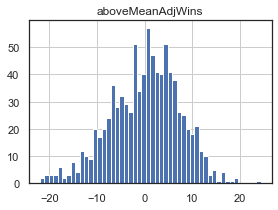


X continuous descriptive stats:


,aboveMeanAdjWins
count,8.870000e+02
mean,-1.281701e-16
std,7.316449e+00
min,-2.194444e+01
25%,-4.855769e+00
50%,6.071429e-01
75%,5.008929e+00
max,2.431250e+01


In [20]:
# predAboveMeanAdjWins distribution
num_univariate_histogram(df = nhl_df, length = 3, width = 10, rows = 1, col = 2, font = 1)

The aboveMeanAdjWins feature appears to be normally distributed.

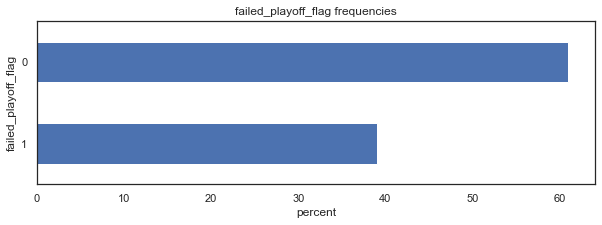

0    61.0
1    39.0
Name: failed_playoff_flag, dtype: float64


In [21]:
# Retaine failed_playoff_flag in a separate data frame
cat_df = nhl_df[['failed_playoff_flag']].astype(str)
# failed_playoff_flag frequency
cat_univariate_freq(df = cat_df, length = 3, width = 10, index_rows = 0, index_col = 1, font = 1)

The above shows the frequencies of playoff outcomes for the tears of study (1983-2020).

#### Bivariate Analysis

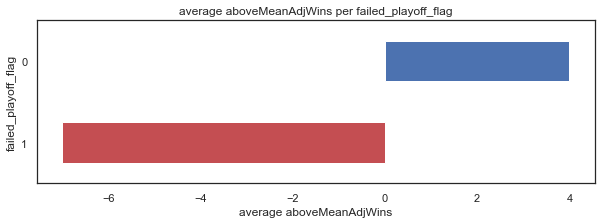

                     aboveMeanAdjWins  positive
failed_playoff_flag                            
0                                 4.0      True
1                                -7.0     False


In [22]:
# Convert failed_playoff_flag to string data type
nhl_df['failed_playoff_flag'] = nhl_df['failed_playoff_flag'].astype(str)
# View averages per playoff outcome
cat_bivariate_avg_target(df = nhl_df, index_rows = 0, index_col = 1, target = 'aboveMeanAdjWins', 
                         length = 3, width = 10, font = 1)

The above shows the bivariate comparison between failed_playoff_flag and average aboveMeanAdjWins.

In [23]:
# Export final data frame to project directory 
nhl_df.to_csv('Data/NHL_1983_2020_Playoff_Data_Removed_Outliers.csv')

The final data frame is exported to the project directory for further analysis.